In [1]:
##Refinement for optimization of boundary conditions to minimize <dH/dx>, average variation in pressure head 
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from writeit import rewritePipes
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
btype = 0   #specifying A (btype =0) or 'Q (btype = 0) at boundary?
case = 0## should be 0,1, or 2
z = (19.67658839,  20.55368162,  17.1443009,   18.20337988)
D = .1            #pipe diameter (m)
Mr = 0.007        #manning roughness coeffs
T = 100          #simulation time (s)
a = 100            #pressure wavespeed
Ltot = 500
Np = 10
Nn = Np+1
K = 6
Ndof = K-2
    
L = 2*Ltot/float(Np)
N = int(L)
dx = L/float(N)
M = max(int(T*a/(dx*.8))*5,1)
Qin =0.0087
Ain =  0.00793018096379

if btype==0:
    bval = Ain
else:
    bval = Qin
oldinp = "../indata/DFDpleasework8.inp"
fn = "../indata/optim_elev_test"
params= (D,N,L,Mr,T,M,a,bval,Qin,Np,fn,oldinp,K,btype)

In [3]:
def f(z,*params):
    D,N,L,Mr,T,M,a,bval,Qin,Np,fn,oldinp,K,btype = params
    x = np.linspace(-1,1,K+1)
    t = np.linspace(-1,1,Np+1)
    if K ==6:
        e0,e1,e2,e3=z
        y = [25,e0,e1,0,e2,e3,15]
    elif K==4:
        e0,e1, = z
        y = [25,e0,0,e1,15]
    s = interpolate.splrep(x,y,s=0)
    elevs = interpolate.splev(t,s,der=0)
    #print K
    #print elevs
    Nn = len(elevs)
    dt = T/float(M)
    Ns = [N]*Np
    Ls = [L]*Np
    Mrs = [Mr]*Np  #manning roughness coeffs
    Ds = [D]*Np      #pipe diameter (m) 
    h0s = [0]*Np    #IC for h
    h0s[0] = 10
    q0s = [0]*Np    #IC for Q
    q0s[0] = Qin
    jt = [1]+[2]*(Nn-2)+[1]  #for DFDpleasework2.inp
    bt = [1]*Nn
    bt[0] = btype
    bv = [0]+[1]*(Nn-1)
    r =  [0]+[1]*(Nn-2)+[-1]
    oldinp = "../indata/DFDpleasework8.inp"
    fn = "../indata/optim_elev_test2"
    (fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)

    return(fi,fc)


In [4]:
fi, fc =f(z,*params)
mtype =1
n0 = PyNetwork(fi, fc, mtype)
M = n0.M


In [5]:
dt = n0.T/n0.M
V0 = n0.getTotalVolume()#get initial volume
n0.setbVal(0,Ain*np.ones(M+1))        #set boundary value time series at node 0 to Q00
n0.runForwardProblem(dt)  #solve up to time T
Vf = n0.getTotalVolume()  #get final volume


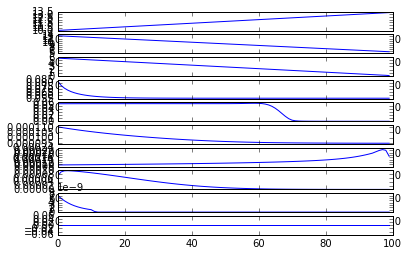

In [6]:
#plot the water height in each pipe at time T
hi = [n0.getHofA(i) for i in range(Np)]
fig,ax = plt.subplots(nrows = n0.Nedges)
x00 = [0,0,0]
for k in range(n0.Nedges):
    #x = np.arange(0,n0.Ls[k], n0.Ls[k]/n0.Ns[k])+x00[k]*np.ones(size(hi[k]))
    ax[k].plot(hi[k],'b')
dx = n0.Ls[0]/n0.Ns[0]

CFL = 0.160000 
space-average grad(H)
        Q = 0       reflecting
max  0.087207  
mean 13.838785  
864937.893645


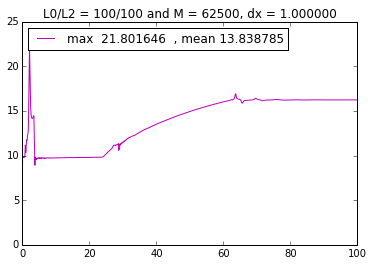

In [7]:
#plot the gradient pressure head at over time
print "CFL = %f " %(dt/dx*n0.a[0])
Hbar = [n0.getAveGradH(i) for i in range(n0.M+1)]
t = np.linspace(0,n0.T,n0.M+1)
kk = 1
plot(t,Hbar,'m')
legend(["max  %f  , mean %f" %(max(Hbar),mean(Hbar))], loc ='upper left')
#savefig("../../gradH_r66.pdf", format='pdf')
title("L0/L2 = %.f/%.f and M = %d, dx = %f"%(n0.Ls[0],n0.Ls[2], n0.M, n0.Ls[0]/n0.Ns[0]))
print "space-average grad(H)"
print "        Q = 0       reflecting"
print "max  %f  " %(max(Hbar)/sqrt(n0.M))
print "mean %f  " %(mean(Hbar))
dx = n0.Ls[0]/n0.Ns[0]
print sum(Hbar)

In [8]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [9]:
Af = np.pi/4.
Vin = Ain  #inflow volume
ndof = 7
md =0
x0 = np.zeros(ndof)  
for i in range((ndof-1)/2):
    x0[2*i+1]= Vin/T
wn=0;#which node you're optimizing the boundary time series for
opt1 = PyBC_opt_dh(fi, fc, ndof, x0, wn, Vin, md)#set up instance of optimization class
Q0orig = opt1.getBCtimeseries()
opt1.compute_f()
f0 = opt1.f
print "f is %f" %f0
print "T is %f" %opt1.T
print "Using %s modes" %opt1.modetype


f is 1327016.480544
T is 100.000000
Using Hermite modes


Vin (specified) = 0.007930
Vin (acutal) = 0.007930
7.93018096379e-05


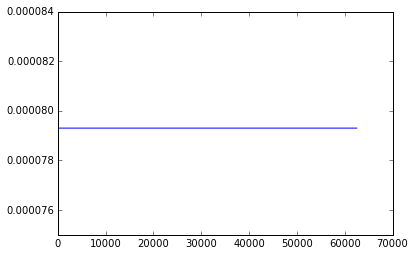

In [10]:
Vin2 = np.trapz(Q0orig, x=t)
print "Vin (specified) = %f" %Vin
print "Vin (acutal) = %f" %Vin2


plot(Q0orig)
print Q0orig[0]

In [12]:
#solve!
opt1.solve()

In [30]:
print "f is %f" %opt1.f
print "f0 - %f"%f0
ff = opt1.f
xf = opt1.x
print "Improvement f_0/f_f is %f" %(ff/f0)
print "components of x_f are\n i &   xf_i  &    x0i\\\\*"
for i in range(len(opt1.x)):
    print "%2d &   %f  & %f\\\\ "%(i+1,xf[i],x0[i]) 

f is 1307328.575618
f0 - 1327016.480544
Improvement f_0/f_f is 0.985164
components of x_f are
 i &   xf_i  &    x0i\\*
 1 &   -0.000000  & 0.000000\\ 
 2 &   0.000078  & 0.000079\\ 
 3 &   0.000000  & 0.000000\\ 
 4 &   0.000079  & 0.000079\\ 
 5 &   -0.000000  & 0.000000\\ 
 6 &   0.000079  & 0.000079\\ 
 7 &   -0.000000  & 0.000000\\ 


In [23]:
#make a place to put the data
import os
lucky = 1e6  #you feeling lucky today pal? use this to use include a random number in filename to ensure you don't write over old data
kk = np.int(lucky*np.random.rand())
where = "../dhdx_results_ndof%d_wavespeed_%03.f_improvement_%f/"%(ndof,n0.a[0],ff/f0)
if not os.path.exists(where):
    os.makedirs(where)

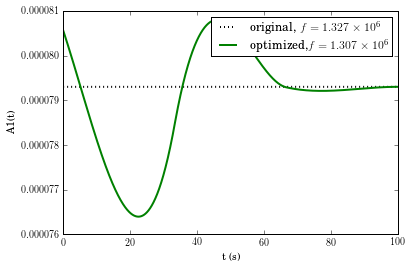

In [25]:
#plot the boundary time series before and after optimization
rc('text', usetex=True)
rc('font', family='serif')
ff = opt1.f
Q01 = opt1.getBCtimeseries()
t = np.linspace(0,opt1.T, opt1.M+1)
fig,ax = plt.subplots(nrows = 1)
ax.plot(t,Q0orig,'k:', linewidth = 2)#,t,np.zeros(opt1.M+1),'r')
ax.plot(t,Q01,'g', linewidth = 2)
ax.set_ylabel('A1(t)')
s0 = "%.3e"%f0
sf = "%.3e"%ff
w0 = s0.find('e')
wf = sf.find('e')
p0 = int(s0[w0+2:])
pf = int(sf[wf+2:])
legend([r'original, $f = %s\times10^%1.d$'%(s0[0:w0],p0), r'optimized,$f = %s\times10^%1.d$'%(sf[0:wf],pf)], loc = 'upper right')
ax.set_xlabel('t (s)')
#where ="/Users/lieba/Desktop/"
savefig(where+"opt_dh_A_nod%d.eps"%ndof, format='eps')

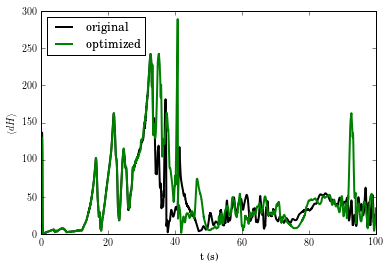

In [26]:
#plot <dH/dx> as a function of time for each bc time series
n2 = PyNetwork(fi, fc, mtype)
n3 = PyNetwork(fi,fc, mtype)
n2.setbVal(0,Q0orig)
n3.setbVal(0,Q01)
n2.runForwardProblem(dt)
n3.runForwardProblem(dt)
xf = opt1.x
Hbar2 = [n2.getAveGradH(i) for i in range(n0.M+1)]
Hbar3 = [n3.getAveGradH(i) for i in range(n0.M+1)]
plot(t,Hbar2, 'k', t,Hbar3,'g', linewidth=2)
ax = gca()
legend(['original', 'optimized'], loc = 'upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel(r"$\langle dH \rangle$")
#where ="/Users/lieba/Desktop/"
savefig(where+"opt_dh_A_ndof%d.eps"%ndof, format='eps')

In [27]:

#save results to a labeled folder 
with open(where+"more_info.txt",'w') as fout:
    fout.write("data (Q0, Qf) pickled to Q0.p and Qf.p\n\n")
    fout.write("to generate whole history, load them and run:\n\
                n0 = PyNetwork(fi,fc, 1)\n\
                n0.setbVal(0,Q)\n\
                n0.runForwardProblem(dt)\n\
                for Q = Q00 or Q = Qf\n\n")
    fout.write("***************************************************************\n")
    fout.write( "interpolation   CPU solve t  actual solve t    f0             ff            ff/f0      Vin   \n")  
    fout.write( "%s         %.2f    %.2f     %e     %e    %.5f   %.2f\n"%(opt1.modetype,opt1.solve_t, opt1.wsolve_t,f0, ff, ff/f0, Vin))
    fout.write("***************************************************************\n")
    fout.write("x0                   xf\n")
    for i in range(len(x0)):
        fout.write("%.15f    %.15f\n"%(x0[i],xf[i]))
import shutil
shutil.copy(fi,where)
shutil.copy(fc,where)
import pickle
pickle.dump(Q00, open(where+"Q0.p", "wb"))
pickle.dump(Q01, open(where+"Qf.p", "wb"))
print "results saved to %s"%where

NameError: name 'Q00' is not defined

In [ ]:
print "CPU solve t  actual solve t    ff/f0"  
print " %.2f         %.2f         %.5f"%(opt1.solve_t, opt1.wsolve_t,ff/f0)

In [ ]:
print where